# Tutorial 1: Poisson equation

In this tutorial, we will learn

   -  How to solve a simple PDE in Julia with GalerkinToolkit
   -  How to load a discrete model (aka a FE mesh) from a file
   -  How to build a conforming Lagrangian FE space
   -  How to define the different terms in a weak form
   -  How to impose Dirichlet and Neumann boundary conditions
   -  How to visualize results


## Problem statement

In this first tutorial, we provide an overview of a complete simulation pipeline in GalerkinToolkit: from the construction of the FE mesh to the visualization of the computed results. To this end, we consider a simple model problem: the Poisson equation.
 We want to solve the Poisson equation on the 3D domain depicted in next figure with Dirichlet and Neumann boundary conditions. Dirichlet boundary conditions are applied on $\Gamma_{\rm D}$, being the outer sides of the prism (marked in red). Non-homogeneous Neumann conditions are applied to the internal boundaries $\Gamma_{\rm G}$, $\Gamma_{\rm Y}$, and $\Gamma_{\rm B}$ (marked in green, yellow and blue respectively). And homogeneous Neumann boundary conditions are applied in $\Gamma_{\rm W}$, the remaining portion of the boundary (marked in white).

![](../docs/src/assets/poisson/model-r1-2.png)

 Formally, the problem to solve is: find the scalar field $u$ such that

$$
\left\lbrace
\begin{aligned}
-\Delta u = f  \ &\text{in} \ \Omega,\\
u = g \ &\text{on}\ \Gamma_{\rm D},\\
\nabla u\cdot n = h \ &\text{on}\  \Gamma_{\rm N},\\
\end{aligned}
\right.
$$
 being $n$ the outwards unit normal vector to the Neumann boundary $\Gamma_{\rm N} \doteq \Gamma_{\rm G}\cup\Gamma_{\rm Y}\cup\Gamma_{\rm B}\cup\Gamma_{\rm W}$. In this example, we chose $f(x) = 1$, $g(x) = 2$, and $h(x)=3$ on $\Gamma_{\rm G}\cup\Gamma_{\rm Y}\cup\Gamma_{\rm B}$ and $h(x)=0$ on $\Gamma_{\rm W}$. The variable $x$ is the position vector $x=(x_1,x_2,x_3)$.

 ## Numerical scheme

 To solve this PDE, we use a conventional Galerkin finite element (FE) method with conforming Lagrangian FE spaces (see, e.g., [1] for specific details on this formulation). The weak form associated with this formulation is: find $u\in U_g$ such that $ a(u,v) = b(v) $ for all $v\in V_0$, where $U_g$ and $V_0$ are the subset of functions in $H^1(\Omega)$ that fulfill the Dirichlet boundary condition $g$ and $0$ respectively. The bilinear and linear forms for this problems are
$$
  a(u,v) \doteq \int_{\Omega} \nabla v \cdot \nabla u \ {\rm d}\Omega, \quad b(v) \doteq \int_{\Omega} v\ f  \ {\rm  d}\Omega + \int_{\Gamma_{\rm N}} v\ h \ {\rm d}\Gamma_{\rm N}.
$$
The problem is solved numerically by approximating the spaces $U_g$ and $V_0$ by their discrete counterparts associated with a FE mesh of the computational domain $\Omega$. As we have anticipated, we consider standard conforming Lagrangian FE spaces for this purpose.

The implementation of this numerical scheme in GalerkinToolkit is done in a user-friendly way thanks to the abstractions provided by the library. As it will be seen below, all the mathematical objects involved in the definition of the discrete weak problem have a correspondent representation in the code.

 ## Setup

Import the GalerkinToolkit library in the code:

In [1]:
import GalerkinToolkit as GT

## Computational mesh

Load a FE mesh:

In [26]:
mesh = GT.mesh_from_gmsh("../docs/src/assets/model.msh")

Info    : Reading '../docs/src/assets/model.msh'...
Info    : 95 entities
Info    : 7475 nodes
Info    : 40330 elements
Info    : Done reading '../docs/src/assets/model.msh'


GalerkinToolkit.GenericMesh(…)

Note that the file `"model.msh"` (which contains a FE mesh and information about user-defined physical boundaries) was generated by using the [GMSH](http://gmsh.info/) mesh generator. See the documentation of [GMSH](http://gmsh.info/#Documentation).

Plot the mesh using [Makie](https://docs.makie.org/) and [GLMakie](https://docs.makie.org/stable/explanations/backends/glmakie#GLMakie) backend:

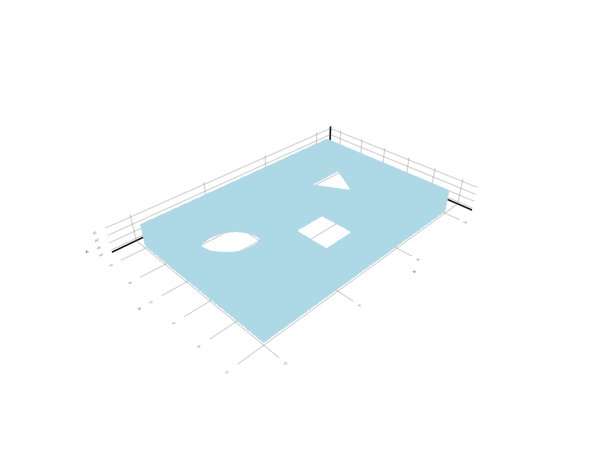

In [36]:
using GLMakie

# for a larger figures
#f = Figure(; size = (1500, 1500))
#lscene = LScene(f[1, 1])
#GLMakie.plot!(lscene,mesh,strokecolor=:black)
#f

GLMakie.plot(mesh)

## Computational domains

Define the discrete solution space:

In [4]:
Ω = GT.interior(mesh;physical_names=["volume"])

GalerkinToolkit.PhysicalDomain(…)

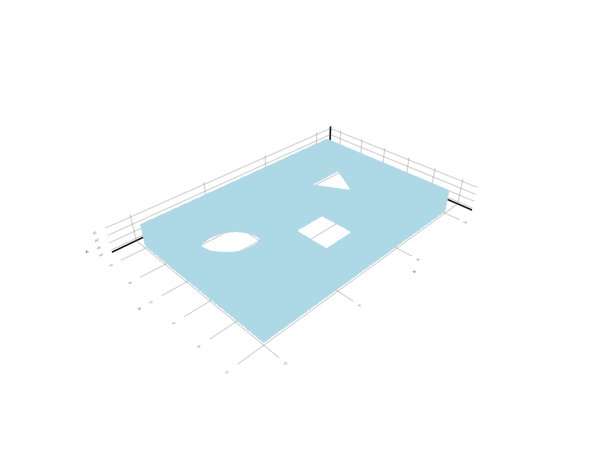

In [5]:
GLMakie.plot(Ω)

Define the Dirichlet boundary $\Gamma_{\rm D}$:

In [6]:
Γd = GT.boundary(mesh;physical_names=["sides"])

GalerkinToolkit.PhysicalDomain(…)

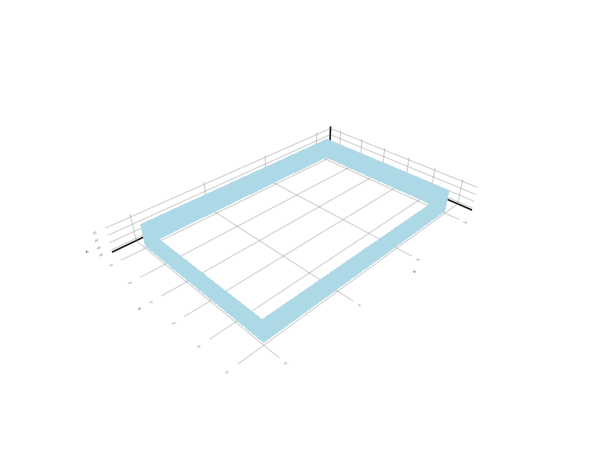

In [7]:
GLMakie.plot(Γd)

Define the Neumann boundary $\Gamma_{\rm N}$:

In [8]:
Γn = GT.boundary(mesh;physical_names=["circle", "triangle", "square"])

GalerkinToolkit.PhysicalDomain(…)

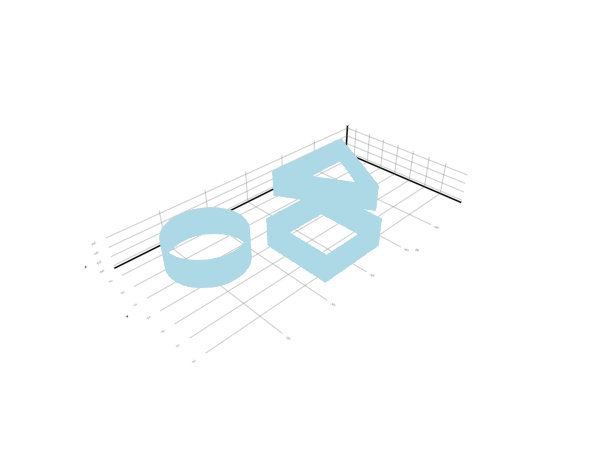

In [9]:
GLMakie.plot(Γn)

## FE spaces

Set up a finite element space:

In [10]:
order = 1
V = GT.lagrange_space(Ω,order;dirichlet_boundary=Γd)

GalerkinToolkit.LagrangeSpace(…)

In [11]:
uhd = GT.dirichlet_field(Float64,V)
g = GT.analytical_field(Ω) do x
    sum(x)
end
GT.interpolate_dirichlet!(g,uhd)

GalerkinToolkit.DiscreteField(…)

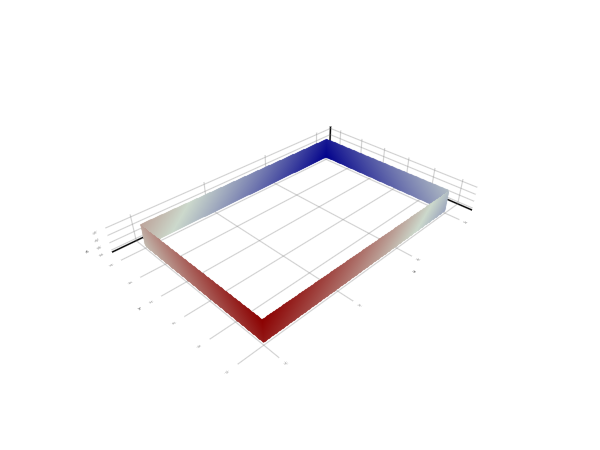

In [12]:
GLMakie.plot(Γd,color=g)

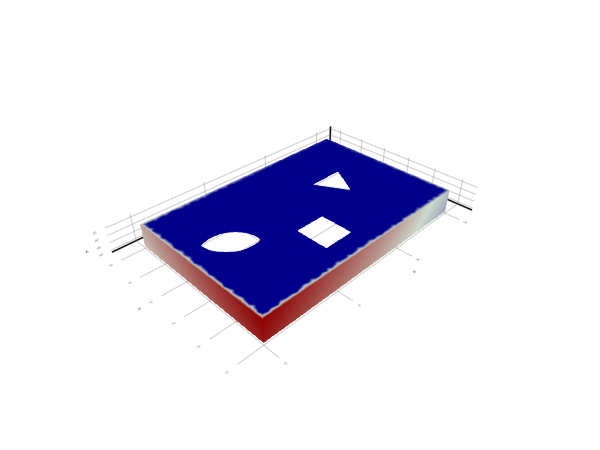

In [13]:
GLMakie.plot(Ω,color=uhd)

## Numerical integration

Compute $\Omega$ integration domain:

In [14]:
degree = 2*order
dΩ = GT.measure(Ω,degree)

GalerkinToolkit.Measure(…)

Compute $\Gamma_{\rm N}$ integration domain:

In [15]:
dΓn = GT.measure(Γn,degree)

GalerkinToolkit.Measure(…)

## Differential operators

Define the gradient operator and generic function:

In [16]:
using ForwardDiff

gradient(u) = x->ForwardDiff.gradient(u,x)
∇(u,x) = GT.call(gradient,u)(x)

∇ (generic function with 1 method)

## Weak form

Define functions representing the bi-linear and linear forms:

In [17]:
using LinearAlgebra

f = GT.analytical_field(Ω) do x
    1.0
end
h = GT.analytical_field(Ω) do x
    3.0
end

a(u,v) = GT.∫( x->∇(u,x)⋅∇(v,x), dΩ)
l(v) = GT.∫( x->v(x)*f(x), dΩ) + GT.∫( x->v(x)*h(x),dΓn)

l (generic function with 1 method)

 ## FE Problem

Build up the linear problem:

In [18]:
x,A,b = GT.linear_problem(uhd,a,l)

([7.291212384108405e-304, 2.121995791e-314, 2.834986376732e-311, 4.0474e-320, 2.529418982843e-311, 0.0, 0.0, 0.0, 7.875e-321, 6.76e-321  …  2.6704900206e-314, 8.487983168e-314, 2.1219957924e-314, NaN, NaN, NaN, 2.842271464e-314, 2.6704684467e-314, 0.0, 5.21502070370693e-310], sparse([1, 22, 74, 289, 337, 338, 339, 340, 341, 1872  …  6303, 335, 465, 467, 468, 1806, 6201, 6224, 6232, 6304], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  6303, 6304, 6304, 6304, 6304, 6304, 6304, 6304, 6304, 6304], [0.06443080405538211, -0.0011816946972152084, -0.0019141180663583925, -0.03255921926190384, -0.013954244941888471, -0.009620087896820673, -0.0021278804315064915, -0.004654033162377993, -0.005173786773138719, 0.003329780400807812  …  0.21999530084991323, -0.015615599976174236, 0.003972555304119093, -0.009088995023018824, -0.00030902681072076353, -0.013784861561036393, -0.014076977113079436, -0.024457375688586837, -0.013734513123868308, 0.17287503833373258], 6304, 6304), [0.0015677351619201938, 0.0015207565876

## Solver phase

 Solve the linear system:

In [19]:
x .= A\b

6304-element Vector{Float64}:
 0.583983093442735
 2.080513886884785
 2.383517868303316
 3.678673361557304
 3.6304538438432963
 2.659196595893013
 3.3109024299487757
 2.3000125990285785
 1.9571913681097337
 3.2446815470013384
 0.6070946802454475
 2.0767748974364917
 2.385048334143519
 ⋮
 3.4554164897441195
 2.1526565397492563
 2.5052713709379653
 0.8436925250103349
 3.663735716962159
 2.8473164198005643
 3.6026210550320883
 1.9241105367780258
 2.120869552315746
 1.5432753167154554
 3.5462578026955396
 2.4914847685009494

Build the PDE solution from the basis-set coefficients in $x$:

In [20]:
uh = GT.solution_field(uhd,x)

GalerkinToolkit.DiscreteField(…)

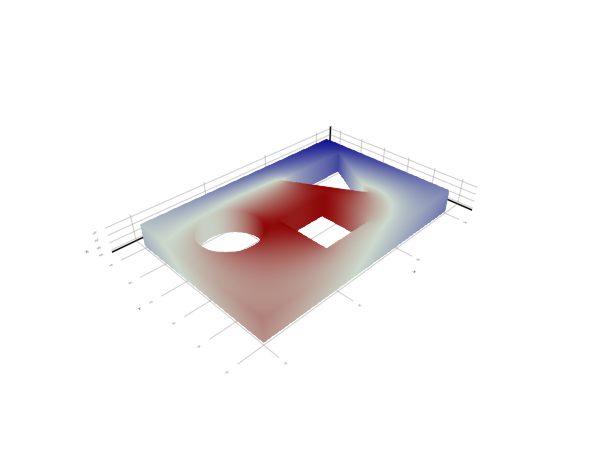

In [21]:
GLMakie.plot(Ω,color=uh)

## References

[1] C. Johnson. *Numerical Solution of Partial Differential Equations by the Finite Element Method*. Dover Publications, 2009.